In [19]:
import os
import logging
from pathlib import Path

from dotenv import dotenv_values
import wandb
import numpy as np
import torch
import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from exrep.registry import load_data, save_data, load_model, load_tensor, get_artifact, save_tensor

if 'notebooks' in os.getcwd():
    os.chdir("../")

local_config = dotenv_values(".env")
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

random_state = 42

embedding_artifact_name = "imagenet-1k-first-20-take-2000_target-embeddings_mocov3-resnet50"
image_artifact_name = "imagenet-1k-first-20-take-2000_images"
output_phase_name = "surrogate"

run = wandb.init(
    project=local_config["WANDB_PROJECT"],
    config={
        "job_type": "train_representation",
        "num_clusters": 20,
    },
    # reinit=True,
    # save_code=True,
)

device = "cuda:4"

In [20]:
train_configs = {
    "surrogate": dict(
        output_dim=32,
    ),
    "loss": dict(
        name="KDLoss",
        gamma1=1.0,
        gamma2=1.0,
        temp_student=0.2,
        temp_teacher=1,
    ),
    "optimizer": dict(
        lr=1e-3,
        weight_decay=1e-4,
    )
}
run.config.update(train_configs)

In [ ]:
%load_ext autoreload
%autoreload 2

from scripts.train_surrogate import train_surrogate_experiment

model, logs = train_surrogate_experiment(run, device=device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/blue/thai/hoangx/projects/explain-representation/exrep/registry.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file_path, map_location=map_locati

(LocalRepresentationApproximator(
   (query_encoder): Linear(in_features=20, out_features=32, bias=True)
   (key_encoder): Linear(in_features=2048, out_features=32, bias=True)
 ),
 {'train': [{'epoch': 0,
    'step': 1,
    'loss_reg': 0.0,
    'grad_estimator': 1.2089556455612183,
    'loss': 1.2089556455612183},
   {'epoch': 0,
    'step': 2,
    'loss_reg': 0.0,
    'grad_estimator': 0.9695155620574951,
    'loss': 0.9695155620574951},
   {'epoch': 0,
    'step': 3,
    'loss_reg': 0.0,
    'grad_estimator': 0.8964020013809204,
    'loss': 0.8964020013809204},
   {'epoch': 0,
    'step': 4,
    'loss_reg': 0.0,
    'grad_estimator': 0.8028238415718079,
    'loss': 0.8028238415718079},
   {'epoch': 1,
    'step': 5,
    'loss_reg': 0.0,
    'grad_estimator': 0.8424233198165894,
    'loss': 0.8424233198165894},
   {'epoch': 1,
    'step': 6,
    'loss_reg': 0.0,
    'grad_estimator': 0.8037910461425781,
    'loss': 0.8037910461425781},
   {'epoch': 1,
    'step': 7,
    'loss_reg': 0.

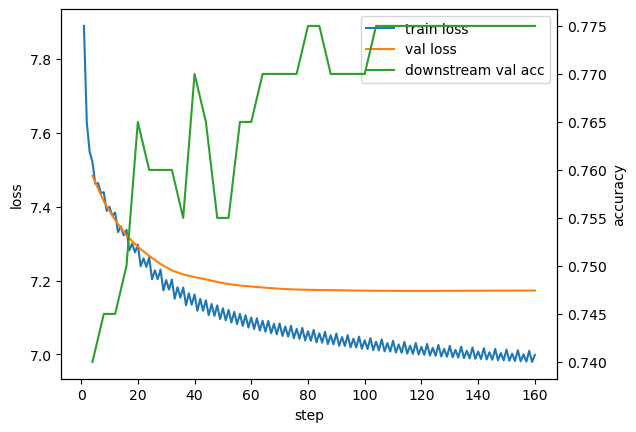

In [5]:
fig, ax = plt.subplots()

twin1 = ax.twinx()

p1, = ax.plot([log["step"] for log in logs["train"]], [log["loss"] for log in logs["train"]], 'C0', label="train loss")
p2, = ax.plot([log["step"] for log in logs["val"]], [log["val_loss"] for log in logs["val"]], 'C1', label="val loss")
p3, = twin1.plot([log["step"] for log in logs["val"]], [log["classify_val_acc"] for log in logs["val"]], 'C2', label="downstream val acc")
# p4, = ax.plot([log["step"] for log in logs["train"]], [log["grad_estimator"] for log in logs["train"]], 'C3', label="train total loss")

ax.set_ylabel("loss")
ax.set_xlabel("step")
# ax.set_ylim([0, 1])
twin1.set_ylabel("accuracy")
ax.legend(handles=[p1, p2, p3])

In [6]:
samples_batch = xy_dataset["train"][:100]
keys_batch = embeddings[:100]

In [15]:
batch_teacher_student = ((samples_batch["targets"] @ samples_batch["targets"].T) / train_configs['loss']['temp_teacher']).to(device)
torch.round(torch.softmax(batch_teacher_student, dim=-1), decimals=3)

tensor([[0.6420, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0080, 0.0250, 0.0100,  ..., 0.0120, 0.0100, 0.0090],
        [0.0000, 0.0000, 0.4610,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0060, 0.0050, 0.0060,  ..., 0.2170, 0.0080, 0.0070],
        [0.0010, 0.0010, 0.0020,  ..., 0.0010, 0.5130, 0.0020],
        [0.0070, 0.0050, 0.0070,  ..., 0.0090, 0.0120, 0.0960]],
       device='cuda:4')

In [16]:
q, k = model.encode(query=samples_batch["inputs"].to(device), key=samples_batch["targets"].to(device), normalize=True)
batch_sim_student = q @ k.T / model.temperature
torch.softmax(batch_sim_student, dim=1)

tensor([[0.0275, 0.0029, 0.0044,  ..., 0.0078, 0.0090, 0.0050],
        [0.0122, 0.0034, 0.0068,  ..., 0.0081, 0.0052, 0.0085],
        [0.0011, 0.0005, 0.1882,  ..., 0.0013, 0.0071, 0.0007],
        ...,
        [0.0066, 0.0034, 0.0041,  ..., 0.0185, 0.0186, 0.0109],
        [0.0061, 0.0027, 0.0037,  ..., 0.0107, 0.0846, 0.0088],
        [0.0121, 0.0045, 0.0167,  ..., 0.0082, 0.0050, 0.0091]],
       device='cuda:4', grad_fn=<SoftmaxBackward0>)

In [23]:
prob_teacher = torch.softmax(batch_teacher_student, dim=1)
prob_student = torch.softmax(batch_sim_student, dim=1)

In [19]:
kl_loss = torch.nn.functional.kl_div(input=torch.log_softmax(batch_sim_student, dim=1), target=torch.softmax(batch_teacher_student, dim=1), reduction="batchmean")
ce_loss = torch.nn.functional.cross_entropy(batch_sim_student, torch.softmax(batch_teacher_student, dim=1))

kl_loss, ce_loss

(tensor(0.9743, device='cuda:4', grad_fn=<DivBackward0>),
 tensor(3.7546, device='cuda:4', grad_fn=<DivBackward1>))

In [9]:
image_dataset = load_data(
    base_name="imagenet-1k-first-20-take-2000",
    phase="images",
    wandb_run=run,
)

wandb: Downloading large artifact imagenet-1k-first-20-take-2000_images:latest, 230.91MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.8


In [80]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

downstream_labels = image_dataset["label"]
pred_embeds = model.encode(query=encoding.float().to(device), normalize=True).detach().cpu().numpy()
target_embeds = embeddings.cpu().numpy()

Y_train, Y_test, P_train, P_test, K_train, K_test = train_test_split(downstream_labels, pred_embeds, target_embeds, random_state=random_state, test_size=0.1, stratify=downstream_labels)
print(len(Y_train), len(Y_test), len(P_train), len(P_test), len(K_train), len(K_test))

classifier = SVC(kernel="linear").fit(K_train, Y_train)
orig_preds = classifier.predict(K_test)
# surrogate_preds = classifier.predict(P_test)

1800 200 1800 200 1800 200


In [57]:
model.query_encoder.weight.shape

torch.Size([16, 20])

In [81]:
surrogate_classifier = SVC(kernel="linear").fit(P_train, Y_train)
surrogate_preds = surrogate_classifier.predict(P_test)

surrogate_acc = (surrogate_preds == Y_test).mean()

print(f"Surrogate accuracy: {surrogate_acc}")
print("Original accuracy:", (orig_preds == Y_test).mean(), "Surrogate accuracy:", (surrogate_preds == Y_test).mean())

Surrogate accuracy: 0.695
Original accuracy: 0.735 Surrogate accuracy: 0.695


In [82]:
matcher_classifier = SVC(kernel="linear").fit(P_train, classifier.predict(K_train).reshape(-1, 1))
surrogate_preds = surrogate_classifier.predict(P_test)

surrogate_acc = (surrogate_preds == classifier.predict(K_test)).mean()

print(f"Surrogate matching accuracy: {surrogate_acc}")

/home/hoangx/persist/envs/exrep/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Surrogate matching accuracy: 0.615


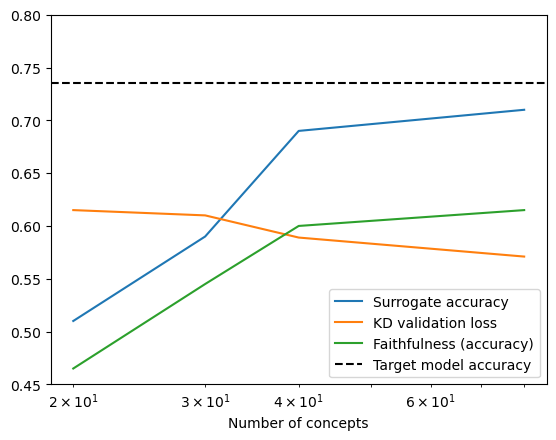

In [98]:
import matplotlib.pyplot as plt

x = [20, 30, 40, 80]
y1 = [0.51, 0.59, 0.69, 0.71]
y2 = [0.615, 0.61, 0.589, 0.571]
y3 = [0.465, 0.545, 0.6, 0.615]

fig, ax = plt.subplots()
ax.plot(x, y1, label="Surrogate accuracy")
ax.plot(x, y2, label="KD validation loss")
ax.plot(x, y3, label="Faithfulness (accuracy)")
ax.set_xlabel("Number of concepts")
plt.axhline(y=0.735, linestyle="--", color="black", label="Target model accuracy")
ax.set_ybound(0.45, 0.8)
# set x log scale
ax.set_xscale('log')
ax.legend()

plt.show()